# Advanced Example
In this advanced example two input files, a spectrum file and a manually created Settings object are used to generate a basic data set for an Earth-like planet orbiting a Sun-like star 10 pc away. The Settings object will overwrite the settings specified in the config file. The code is run on GPU #0 in detailed mode, thus also saving and outputting the intensity responses.

## Import modules and specify paths
Note: The ``spectrum_files`` **must** be a tuple of planet name/spectrum file path tuples. If only for one planet
a spectrum file should be provided, then the trailing comma after that planet name/spectrum tuple is essential to
still make the input a tuple of tuples, i.e. ``(('Planet Name', Path('path_to_planet_name_spectrum_file')),)`` and
not ``(('Planet Name', Path('path_to_planet_name_spectrum_file')))``.

In [12]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch

from phringe.core.entities.settings import Settings
from phringe.phringe_ui import PHRINGE

path_to_config_file = Path('../config.yaml')
path_to_exoplanetary_system_file = Path('../exoplanetary_system.yaml')
spectrum_files = (('Earth', Path('../spectrum.txt')),)

## Create Settings Object
Note: passing a ``Settings`` object to the run method will overwrite the settings specified in the config file.  

In [13]:
settings = Settings(
    grid_size=100,
    time_step_size='100 s',
    has_planet_orbital_motion=False,
    has_stellar_leakage=True,
    has_local_zodi_leakage=True,
    has_exozodi_leakage=False,
    has_amplitude_perturbations=True,
    has_phase_perturbations=True,
    has_polarization_perturbations=True
)

## Run PHRINGE on GPU
Note the specification of the zeroth GPU to be used for the calculations. See the documentation of [PHRINGE.run()](../source/phringe.html#class-phringe) for more information on the parameters.

In [17]:
phringe = PHRINGE()
phringe.run(
    config_file_path=path_to_config_file,
    exoplanetary_system_file_path=path_to_exoplanetary_system_file,
    settings=settings,
    gpus=(0,),
    output_dir=Path('.'),
    fits_suffix='',
    detailed=True,
    write_fits=True,
    create_copy=True,
    create_directory=True,
    normalize=False
)

## Retrieve Data and Simulation Parameters

In [18]:
data = phringe.get_data()
wavelengths = phringe.get_wavelength_bin_centers().numpy()
time_steps = phringe.get_time_steps()
fov = phringe.get_field_of_view()
intensity_response = phringe.get_intensity_response()['Earth']

## Plot Data and Differential Intensity Response

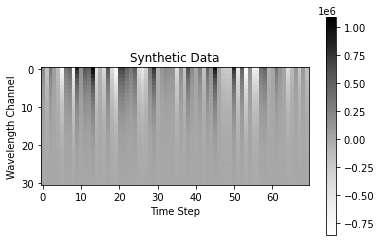

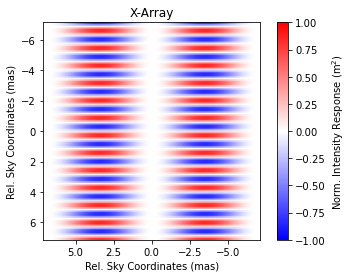

In [19]:
wavelengths = [round(wavelength * 1e6, 1) for wavelength in wavelengths]
time_steps = [int(round(time, 0)) for time in time_steps.numpy()]
wavelength_index = 6
fov = (fov[wavelength_index] / 2) * 2.063e8
differential_ir = intensity_response[wavelength_index, 2] - intensity_response[wavelength_index, 3]
differential_ir /= torch.max(abs(differential_ir))

plt.imshow(data[0], cmap='Greys')
plt.title('Synthetic Data')
plt.ylabel('Wavelength Channel')
plt.xlabel('Time Step')
plt.colorbar()
plt.show()

im = plt.imshow(differential_ir[0], cmap='bwr', extent=(fov, -fov, fov, -fov), vmin=-1, vmax=1)
plt.title('X-Array')
plt.xlabel('Rel. Sky Coordinates (mas)')
plt.ylabel('Rel. Sky Coordinates (mas)')
cb = plt.colorbar(im)
cb.set_label(label='Norm. Intensity Response (m$^2$)')
plt.show()